Hello and welcome to this notebook in which we will go over the CapitalOne fraud detection challenge.

This notebook is organized as follows:


    
    ├── Question 1 : Load      
    │   ├── Data Loading
    │   ├── Structure Desctiption
    │   └── Basic Summary Statistics
    │      
    ├── Question 2 : Plot   
    │   └── Histogram Plot
    │      
    ├── Question 3 : Data Wrangling -  Duplicate Transactions
    │   ├── Reversed Transactions
    │   └── Multi-Swipe Transactions (4902)
    │
    ├── Question 4 : Model 
    │   ├── Data Preparation
    │   ├── Feature Engineering
    │   ├── Naive Model (baseline)
    │   ├── XGBoost Model
    │   ├── XGBoost Model
    │   └── Temporally Correlated Features
    │
    ├── Conclusion
        └── Ideas for improvement (time-series analysis)



# Question 1: Load ⌛

In this section we will programmatically download and load the transactions data. To do this we will follow the following steps:

1. Download the data which can be found [here](https://github.com/CapitalOneRecruiting/DS/raw/master/transactions.zip)
2. Extract the data
3. Convert the data into json
4. Load the data as a pandas dataframe.

After that, we will describe the structure of the data and also provide some additional basic summary statistics for each field.

## Data Loading

The following fetches the dataset from [here](https://github.com/CapitalOneRecruiting/DS/raw/master/transactions.zip) and converts it into a JSON file.

### Step 0: Imports

We first import some libraries to help us with the data loading part.

Make sure to first install all requirements in requirements.txt

In [ ]:
import requests
import zipfile
import os
import json
import pandas as pd

pd.set_option('display.max_columns', None)

### Step 1: Download the data

We will use the url to download the zip file locally. The zip file will be placed into a folder to keep things organized.

In [ ]:
# --- Download the data ---

url = 'https://github.com/CapitalOneRecruiting/DS/raw/master/transactions.zip'

# Create the extraction directory
extract_path = 'transactions_data'
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Define zip path
zip_path = 'transactions_data/transactions.zip'
response = requests.get(url, stream=True)

# Write the downloaded data to a file in binary mode
with open(zip_path, 'wb') as f:
    for chunk in response.iter_content(chunk_size=128):
        f.write(chunk)

print(f"Downloaded '{zip_path}'")

Downloaded 'transactions_data/transactions.zip'


### Step 2: Extract the data

This is a simple step and helps us gain access to `transactions.txt`


In [ ]:
# --- Unzip the Data ---
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print(f"Extracted files to '{extract_path}'")

Extracted files to 'transactions_data'


### Step 3: Load as a pd.DataFrame

Next, we read the txt file and load it into a pandas dataframe.

In [ ]:
# --- Load the Data ---
# File locations for loading
input_filename = 'transactions_data/transactions.txt'

data = []
with open(input_filename, 'r') as infile:
    for line in infile:
        json_obj = json.loads(line)
        if json_obj:
            data.append(json_obj)

df = pd.DataFrame(data)
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.0,,,,True,,,False,False


## Description of the structure of the data

These cells provide a description of the structure of the data, starting with identifying the different eterogeneous data in each record.

In [ ]:
# Get the number of records
num_records = len(df)

# Print the records and the different fields
print(f"Number of records: {num_records}")
print(f"Fields in each record: {list(df.keys())}")

Number of records: 786363
Fields in each record: ['accountNumber', 'customerId', 'creditLimit', 'availableMoney', 'transactionDateTime', 'transactionAmount', 'merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'transactionType', 'echoBuffer', 'currentBalance', 'merchantCity', 'merchantState', 'merchantZip', 'cardPresent', 'posOnPremises', 'recurringAuthInd', 'expirationDateKeyInMatch', 'isFraud']


The data represents financial transaction records, as mentioned in the description of the problem. We could further break down the 29 columns into categories:

* **Customer & Account Information**
    * `accountNumber` : The account number of the record.
    * `customerId` : The customer ID of the record.
    * `creditLimit` : The credit limit of the record.
    * `availableMoney` : How much money is available.
    * `accountOpenDate` : The date the account was opened.<br>
    ...<br>
<br>

* **Transaction Specifics**
    * `transactionDateTime` : Data and time of the transaction
    * `transactionAmount` : Amount of transaction
    * `merchantName` : The name of the merchant where the transaction occurred.
    * `acqCountry` : Country where transaction occured.
    * `merchantCountryCode` : Country code of the merchant.
    * `merchantCategoryCode` : A code characterizing the type of merchant (retail, restaurant, etc)
    * `transactionType` : The type of the transaction (purchase, refund, cash withdrawal)<br>
    ...<br>
<br>

* **Card & Security**
    * `cardCVV` : Secutiry code.
    * `enteredCVV` : CVV entered during the transaction.
    * `cardLast4Digits` : Last 4 digits of the credit card number.
    * `cardPresent` : Boolean flag representing if the card was physically present.
    * `expirationDateKeyInMatch` : Checks if the expiration date entered matches the actual expiration date of the card.<br>
    ...<br>
<br>

* **Geographical**
    * `merchantCity`,`merchantState`,`merchantZip` : Location data of the merchant.<br>
<br>

* **Fraud/Risk Related**
    * `posEntryMode`: Card entry mode (swiped, manually keyed in, etc).
    * `posConditionCode`: Additional info about the point of sale.
    * `recurringAuthInd` : A boolean flag, characterizing the payment as recurring.
    * `isFraud` : Label to indicate whether the transaction was fraudulent.<br>
    ...<br>

Next, let's see what data types are in each column and give some basic summary statistics for each field.

## Basic Summary Statistics

The following cells inform us about some basic statistics that summarize each category.

In [ ]:
numerical_columns = set()
categorical_columns = set()
boolean_columns = set()

for column, dtype in df.dtypes.items():
    dtype_name = dtype.name
    if dtype_name == 'bool':
        boolean_columns.add(column)
    elif dtype_name in ['int64', 'float64']:
        numerical_columns.add(column)
    else:
        categorical_columns.add(column)

print("Numerical Columns:")
print(numerical_columns)
print("\nCategorical Columns:")
print(categorical_columns)
print("\nBoolean Columns:")
print(boolean_columns)

Numerical Columns:
{'currentBalance', 'creditLimit', 'transactionAmount', 'availableMoney'}

Categorical Columns:
{'cardCVV', 'transactionDateTime', 'posEntryMode', 'merchantCategoryCode', 'merchantState', 'posConditionCode', 'merchantName', 'merchantCountryCode', 'merchantZip', 'accountNumber', 'dateOfLastAddressChange', 'currentExpDate', 'echoBuffer', 'merchantCity', 'recurringAuthInd', 'posOnPremises', 'acqCountry', 'cardLast4Digits', 'enteredCVV', 'customerId', 'accountOpenDate', 'transactionType'}

Boolean Columns:
{'isFraud', 'cardPresent', 'expirationDateKeyInMatch'}


In [ ]:
numerical_stats = df[list(numerical_columns)].describe().transpose()
numerical_stats['NaN_count'] = df[list(numerical_columns)].isnull().sum()
print(numerical_stats)

                      count          mean           std      min      25%  \
currentBalance     786363.0   4508.739089   6457.442068     0.00   689.91   
creditLimit        786363.0  10759.464459  11636.174890   250.00  5000.00   
transactionAmount  786363.0    136.985791    147.725569     0.00    33.65   
availableMoney     786363.0   6250.725369   8880.783989 -1005.63  1077.42   

                       50%        75%       max  NaN_count  
currentBalance     2451.76   5291.095  47498.81          0  
creditLimit        7500.00  15000.000  50000.00          0  
transactionAmount    87.90    191.480   2011.54          0  
availableMoney     3184.86   7500.000  50000.00          0  


In [ ]:
categorical_stats = pd.DataFrame(index=list(categorical_columns), columns=['unique_values', 'most_common_freq', 'least_common_freq', 'mean_freq', 'std_dev_freq', 'NaN_count'])
for column in categorical_columns:
    counts = df[column].value_counts()
    categorical_stats.loc[column] = {
        'unique_values': df[column].nunique(),
        'most_common_freq': counts.max(),
        'least_common_freq': counts.min(),
        'mean_freq': counts.mean(),
        'std_dev_freq': counts.std(),
        'NaN_count': df[column].isnull().sum()
    }
print(categorical_stats)

                        unique_values most_common_freq least_common_freq  \
cardCVV                         899.0          33749.0              19.0   
transactionDateTime          776637.0              4.0               1.0   
posEntryMode                      6.0         315035.0            4054.0   
merchantCategoryCode             19.0         202156.0            1382.0   
merchantState                     1.0         786363.0          786363.0   
posConditionCode                  4.0         628787.0             409.0   
merchantName                   2490.0          25613.0               1.0   
merchantCountryCode               5.0         778511.0             724.0   
merchantZip                       1.0         786363.0          786363.0   
accountNumber                  5000.0          32850.0               1.0   
dateOfLastAddressChange        2184.0           3819.0               1.0   
currentExpDate                  165.0           5103.0            1874.0   
echoBuffer  

In [ ]:
boolean_stats = pd.DataFrame(index=list(boolean_columns), columns=['True_count', 'False_count', 'NaN_count'])
for column in boolean_columns:
    boolean_stats.loc[column] = {
        'True_count': df[column].sum(),
        'False_count': df[column].size - df[column].sum() - df[column].isnull().sum(),
        'NaN_count': df[column].isnull().sum()
    }
print(boolean_stats)

                         True_count False_count NaN_count
isFraud                       12417      773946         0
cardPresent                  352868      433495         0
expirationDateKeyInMatch       1043      785320         0


# Question 2: Plot 📊

This part produces a histogram of the processed amounts of each transaction.

### Step 0: Imports

In [ ]:
import matplotlib.pyplot as plt

### Step 1: Plot Histogram

In [ ]:
print(numerical_stats.loc['transactionAmount'])

count        786363.000000
mean            136.985791
std             147.725569
min               0.000000
25%              33.650000
50%              87.900000
75%             191.480000
max            2011.540000
NaN_count         0.000000
Name: transactionAmount, dtype: float64


Text(284.7113599710283, 120268.8375, '1σ')

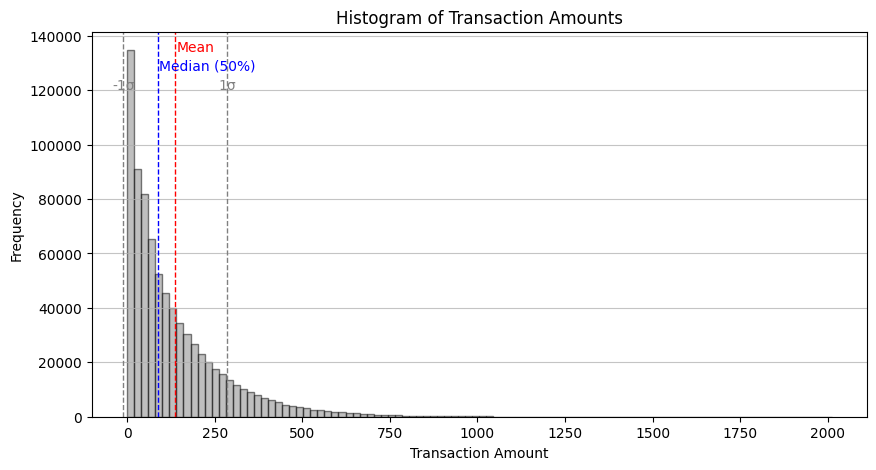

In [ ]:
transaction_stats = numerical_stats.loc['transactionAmount']

plt.figure(figsize=(10, 5))
plt.hist(df['transactionAmount'], bins=100, color='gray', edgecolor='black', alpha=0.5)
plt.title('Histogram of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Adding vertical lines for mean, 25%, 50%, 75%
plt.axvline(transaction_stats['mean'], color='r', linestyle='dashed', linewidth=1)
plt.text(transaction_stats['mean']*1.03, plt.ylim()[1]*0.95, 'Mean', color = 'red')

plt.axvline(transaction_stats['50%'], color='b', linestyle='dashed', linewidth=1)
plt.text(transaction_stats['50%']*1.03, plt.ylim()[1]*0.90, 'Median (50%)', color = 'blue')

std_left = transaction_stats['mean'] - transaction_stats['std']
std_right = transaction_stats['mean'] + transaction_stats['std']

plt.axvline(std_left, color='gray', linestyle='dashed', linewidth=1)
plt.axvline(std_right, color='gray', linestyle='dashed', linewidth=1)

plt.text(std_left, plt.ylim()[1]*0.85, f"-1σ", ha='center', color='gray')
plt.text(std_right, plt.ylim()[1]*0.85, f"1σ", ha='center', color='gray')


Here are some observations about the above data:

<u>**Distribution Skew**</u><br>
Since the mean (136.99) is greater than the median (87.90), the distribution is right-skewed with a long right tail. This is common in expenditure data where a most of the transactions are smaller amounts and there are a few **large transactions** that increase the mean more than the median.<br>
<br>
<u>**Potential Outliers**</u><br>
The maximum transaction is 2011.54, which is ~ 14.68 times larger than the mean. There is a large peak-to-average ratio. Also, the considerable gap between the 75% quantile and the maximum value suggests that there are potential outliers in the higher transaction amount range.<br>
<br>
<u>**Spread**</u><br>
The standard deviation is 147.73 which is relatively large as a statistical measure.

Based on the above, here is a hypothesis about the data:

<u>**Hypotheses**</u><br>
Given the skewness and the spread, one could hypothesize that the dataset contains transactions from various categories or merchants with different average price points. High-value transactions could be fewer and represent big-ticket items or services. Conversely, the bulk of transactions is likely clustered at lower amounts, possibly everyday purchases or small-value items.


# Question 3: Data Wrangling - Duplicate Transactions 🏧

## Identify Reversed

The reversed transactions are in the dataframe under the `'REVERSAL'` column.

In [ ]:
# First we sort by accountNumber and then by transactionDateTime.
sorted_df = df.sort_values(by=['accountNumber', 'transactionDateTime'])

In [ ]:
# Filter the dataset to keep only the transactions where transactionType is 'REVERSAL'
reversed_transactions = sorted_df[sorted_df['transactionType'] == 'REVERSAL']

# Since the original data was sorted by 'accountNumber' and 'transactionDateTime', this subset retains that sorting
print(f"Identified {len(reversed_transactions)} total REVERSED transactions")
print(reversed_transactions['transactionType'].head(10))

Identified 20303 total REVERSED transactions
541964    REVERSAL
87920     REVERSAL
87936     REVERSAL
151499    REVERSAL
151541    REVERSAL
151595    REVERSAL
474247    REVERSAL
474250    REVERSAL
3010      REVERSAL
3052      REVERSAL
Name: transactionType, dtype: object


## Multi-Swipe

Multi-Swipe transactions are characterized by certain phenomena in adjacent transactions, for example:

1. In temporal proximity with a normal transaction.
2. Same accountNumber
3. Same merchantName
4. Same transaction amount

However, things get a little tricky in identifying exactly which time threshold to consider, as we will see below.


### Step 0: Imports

In [ ]:
import numpy as np

In [ ]:
# Convert the transactionDateTime values to datetime64[ns]
sorted_df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])
print(sorted_df['transactionDateTime'])

541900   2016-01-12 00:59:52
541901   2016-01-12 19:49:41
541902   2016-01-17 15:41:46
541903   2016-02-02 19:57:18
541904   2016-02-03 04:48:54
                 ...        
108111   2016-09-16 15:35:24
108112   2016-09-22 13:58:30
108113   2016-10-23 16:47:41
108114   2016-11-24 00:21:46
108115   2016-12-24 05:19:30
Name: transactionDateTime, Length: 786363, dtype: datetime64[ns]


The cell below identifies multi-swipe transactions in a dynamic *range of thresholds*.

This allows us to pinpoint exactly what time to set our threshold.

In [ ]:
def identify_multi_swipe_transactions(df, time_threshold):
    
    # Identifies potential multi-swipe transactions based on matching criteria and time threshold.
    
    threshold_low = '0min'
    threshold_high = '50000min'

    df['time_difference'] = df['transactionDateTime'].diff()

    # Applying all conditions directly on df using the time_condition for correct alignment
    multi_swipe_transactions = df.loc[
        (df['accountNumber'] == df['accountNumber'].shift()) &
        (df['transactionDateTime'] - df['transactionDateTime'].shift() >= pd.Timedelta(threshold_low)) &
        (df['transactionDateTime'] - df['transactionDateTime'].shift() <= pd.Timedelta(threshold_high)) &
        (df['merchantName'] == df['merchantName'].shift()) &
        (df['transactionAmount'] == df['transactionAmount'].shift()) &
        (df['transactionType'] == df['transactionType'].shift()) &
        (df['currentBalance'] - df['transactionAmount'] == df['currentBalance'].shift()) &
        (df['transactionAmount'] > 0)
    ]

    return multi_swipe_transactions

# Usage example:
multi_swipe_transactions = identify_multi_swipe_transactions(sorted_df, time_threshold="1min")

print("Multi-Swipe Transactions:")
print(len(multi_swipe_transactions))

Multi-Swipe Transactions:
6677


The above initial guess accounts for all swipes that met the aforementioned criteria above and were within the (genearous) time threshold provided `(0 - 50000 minutes)`

Now, we would like to know exactly where to draw the time threshold line. The next 3 cells are for debugging.

In [ ]:
multi_swipe_transactions.sort_values(by=['time_difference']).head(10)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,time_difference
253292,380680241,380680241,5000.0,2457.60,2016-05-24 14:31:05,88.10,Fresh Online Services,US,US,05,08,online_gifts,03/2030,2014-06-21,2016-05-24,869,869,593,PURCHASE,,2542.40,,,,False,,,False,False,0 days 00:00:01
445924,588435773,588435773,15000.0,13294.50,2016-04-26 18:34:34,232.67,EZ Putt Putt #503815,US,US,05,01,entertainment,09/2031,2015-08-04,2015-08-04,551,551,5441,PURCHASE,,1705.50,,,,True,,,False,False,0 days 00:00:01
594338,167830614,167830614,2500.0,452.92,2016-02-04 00:54:16,172.26,EZ Putt Putt #755869,US,US,02,01,entertainment,06/2023,2015-12-04,2015-12-04,513,513,8369,PURCHASE,,2047.08,,,,True,,,False,False,0 days 00:00:01
116897,335508125,335508125,15000.0,13923.34,2016-02-06 07:23:40,8.43,John's Cafe,US,US,05,08,food,10/2031,2015-03-20,2015-03-20,569,569,8988,PURCHASE,,1076.66,,,,True,,,False,False,0 days 00:00:01
18181,380503025,380503025,2500.0,1312.23,2016-03-28 04:55:28,161.30,Dunkin' Donuts #454355,US,US,09,01,fastfood,04/2032,2008-06-29,2016-02-13,504,504,6467,PURCHASE,,1187.77,,,,False,,,False,False,0 days 00:00:01
100075,740574175,740574175,15000.0,5374.68,2016-11-07 07:43:32,103.01,Auntie Anne's #851574,US,US,09,08,fastfood,08/2026,2015-08-14,2016-10-25,531,531,6210,PURCHASE,,9625.32,,,,True,,,False,False,0 days 00:00:01
661796,429186605,429186605,50000.0,49516.62,2016-07-24 04:08:22,55.06,AMC #606218,US,US,09,01,entertainment,09/2032,2014-05-22,2016-06-04,765,765,6400,PURCHASE,,483.38,,,,True,,,False,False,0 days 00:00:01
195030,432369445,432369445,7500.0,4968.63,2016-10-05 09:58:56,331.27,apple.com,US,US,09,08,online_retail,09/2029,2014-12-25,2016-01-06,833,833,3615,PURCHASE,,2531.37,,,,False,,,False,False,0 days 00:00:01
311406,794958003,794958003,5000.0,484.28,2016-11-28 22:08:12,115.68,staples.com,US,US,02,01,online_retail,01/2021,2014-12-30,2016-06-16,776,776,1241,PURCHASE,,4515.72,,,,False,,,False,False,0 days 00:00:01
777579,198092241,198092241,7500.0,5714.71,2016-09-23 16:34:53,68.85,williamssonoma.com,US,US,05,08,furniture,12/2023,2014-12-14,2016-09-06,296,296,3156,PURCHASE,,1785.29,,,,True,,,False,False,0 days 00:00:01


In [ ]:
# Define the user and the time window
user_id = '380680241'
time = pd.to_datetime('2016-05-24 14:31:05')
day_range = 10
start_time = time - pd.Timedelta(minutes=day_range)
end_time = time + pd.Timedelta(minutes=day_range)

# Filter the DataFrame
filtered_df = sorted_df[
    (sorted_df['accountNumber'] == user_id) &
    (sorted_df['transactionDateTime'] >= start_time) &
    (sorted_df['transactionDateTime'] <= end_time)
]

# Print the filtered DataFrame
print(filtered_df)

       accountNumber customerId  creditLimit  availableMoney  \
253291     380680241  380680241       5000.0          2545.7   
253292     380680241  380680241       5000.0          2457.6   
253293     380680241  380680241       5000.0          2369.5   

       transactionDateTime  transactionAmount              merchantName  \
253291 2016-05-24 14:31:04              88.10     Fresh Online Services   
253292 2016-05-24 14:31:05              88.10     Fresh Online Services   
253293 2016-05-24 14:32:13             530.16  Next Day Online Services   

       acqCountry merchantCountryCode posEntryMode posConditionCode  \
253291         US                  US           05               08   
253292         US                  US           05               08   
253293         US                  US           09               08   

       merchantCategoryCode currentExpDate accountOpenDate  \
253291         online_gifts        03/2030      2014-06-21   
253292         online_gifts      

In [ ]:
print(multi_swipe_transactions['time_difference'].max())

30 days 18:22:12


If we now plot the time differences in the multi-swipe transactions we see two interestins jumps:

1. Weekly interval - This is when recurring purchases are made and the person did not have any other transactions in the meantime.
3. Biweekly interval - Many subscriptions fall under this category. 

253292          1.0
445924          1.0
594338          1.0
116897          1.0
18181           1.0
            ...    
738702    2602448.0
475634    2617521.0
663875    2640132.0
108234    2651491.0
445298    2658132.0
Name: time_difference, Length: 6677, dtype: float64


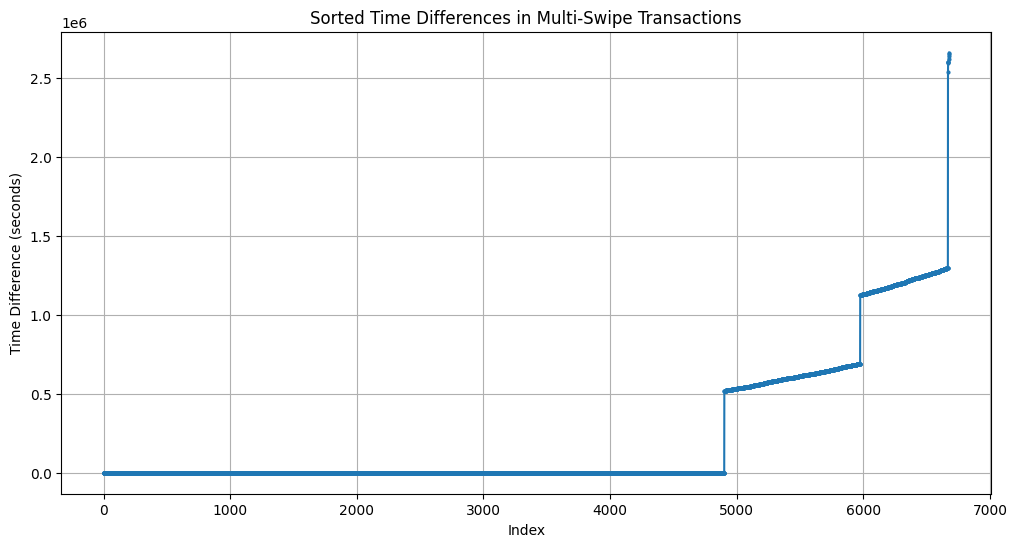

In [ ]:
print(multi_swipe_transactions.sort_values(by=['time_difference'])['time_difference'].dt.total_seconds())

time_differences = np.sort(multi_swipe_transactions['time_difference'].dt.total_seconds())

# Create an array of indices from 0 to the length of time differences
indices = np.arange(len(time_differences))

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(indices, time_differences, marker='o', linestyle='-', markersize=2)

plt.xlabel('Index')
plt.ylabel('Time Difference (seconds)')
plt.title('Sorted Time Differences in Multi-Swipe Transactions')

plt.grid(True)
plt.show()

Now, if we zoom close to the threshold, we see that there is no multi-swipe candidate that had consequtive transactions with more than `179` seconds apart.

In [ ]:
# 101743        179.0
# 520331        179.0
# 605641        179.0
# 711009        179.0
# 679103        179.0
# 65775      518540.0
# 738843     518873.0
# 644778     518986.0
# 650791     519525.0
# 421553     519603.0

We can also see this in a more proper pictorial representation below:

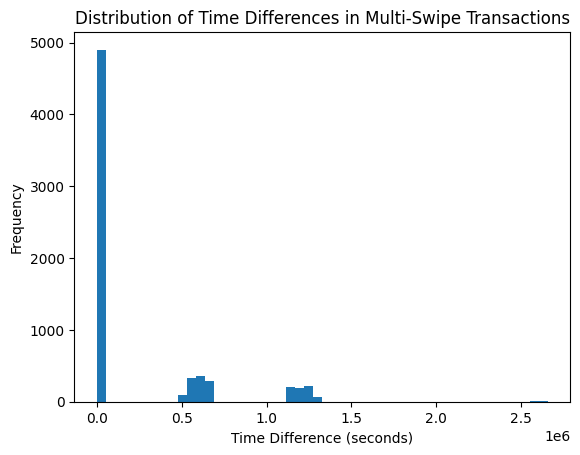

In [ ]:
# Histogram of time differences
plt.hist(multi_swipe_transactions['time_difference'].dt.total_seconds(), bins=50)
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Time Differences in Multi-Swipe Transactions')
plt.show()

Now, we will run our function one more time for `0-200` seconds and extract all the multi-swipes from the dataset.

In [ ]:
def identify_multi_swipe_transactions(df, time_threshold):
    """Identifies potential multi-swipe transactions based on matching criteria and time threshold.
    """
    threshold_low = '0sec'
    threshold_high = '200sec'

    df['time_difference'] = df['transactionDateTime'].diff()

    # Applying all conditions directly on df using the time_condition for correct alignment
    multi_swipe_transactions = df.loc[
        (df['accountNumber'] == df['accountNumber'].shift()) &
        (df['transactionDateTime'] - df['transactionDateTime'].shift() >= pd.Timedelta(threshold_low)) &
        (df['transactionDateTime'] - df['transactionDateTime'].shift() <= pd.Timedelta(threshold_high)) &
        (df['merchantName'] == df['merchantName'].shift()) &
        (df['transactionAmount'] == df['transactionAmount'].shift()) &
        (df['transactionType'] == df['transactionType'].shift()) &
        (df['currentBalance'] - df['transactionAmount'] == df['currentBalance'].shift()) &
        (df['transactionAmount'] > 0)
    ]

    return multi_swipe_transactions

# Usage example:
multi_swipe_transactions = identify_multi_swipe_transactions(sorted_df, time_threshold="1min")

print("Multi-Swipe Transactions:")
print(len(multi_swipe_transactions))

Multi-Swipe Transactions:
4902


## Total number of transactions and total dollar amount for reversed transactions

In [ ]:
tot_reversed = len(reversed_transactions)
tot_multi_swipe = len(multi_swipe_transactions)
tot_reversed_dollars = reversed_transactions['transactionAmount'].sum()
tot_multi_swipe_dollars = multi_swipe_transactions['transactionAmount'].sum()

print("Total number of reversed transactions:", tot_reversed)
print("Total number of multi-swipe transactions:", tot_multi_swipe)
print("Total dollar amount for reversed transactions:", tot_reversed_dollars)
print("Total dollar amount for multi-swipe transactions:", tot_multi_swipe_dollars)

Total number of reversed transactions: 20303
Total number of multi-swipe transactions: 4902
Total dollar amount for reversed transactions: 2821792.5
Total dollar amount for multi-swipe transactions: 656016.61


## Anything interesting?

It is interesting that we have a total of 20303 reversed transactions is worth ~ $2.82M

The total amount for multi-swipe transactions is ~ $656K

# Question 4: Model ⚛️

The quality of our predictions is a strongly correlated to the quality of our data. Therefore, we will do some pre-processing and cleaning to reassure the best possible results from our models.


### Step 0: Imports

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Identify empty columns


In [ ]:
empty_or_blank_columns = df.columns[(df == '').all() | (df.isnull().all())].tolist()
empty_or_blank_columns

['echoBuffer',
 'merchantCity',
 'merchantState',
 'merchantZip',
 'posOnPremises',
 'recurringAuthInd']

In [ ]:
df = df.drop(columns=empty_or_blank_columns)

## Identify numerical and categorical features

In [ ]:
def count_unique_numbers(df, feature_list):
    return pd.DataFrame({
        'feature': feature_list,
        'unique_entry_counts': [df[feature].nunique() for feature in feature_list]
    }).sort_values('unique_entry_counts', ascending=False)

categorical_features = df.select_dtypes(include=['object', 'bool']).columns
count_unique_numbers(df, categorical_features)

,feature,unique_entry_counts
2,transactionDateTime,776637
14,cardLast4Digits,5246
0,accountNumber,5000
1,customerId,5000
3,merchantName,2490
11,dateOfLastAddressChange,2184
10,accountOpenDate,1820
13,enteredCVV,976
12,cardCVV,899
9,currentExpDate,165


The sample complexity of this data is comparable to the dataset itself, which is not practical. Many features need to drop. Let's see how we can reduce the dimensionality of our categorical data without losing much information necessary for our model to predict fraudulent transactions.

### `transactionDateTime` `dateOfLastAddressChange` `accountOpenDate`

We will eventially remove these features, but before we do so we will use the `transactionDateTime` feature to create certain buckets for the `dateOfLastAddressChange` and `accountOpenDate` features.

In [ ]:
proc_df = df.copy(deep=True)

In [ ]:
proc_df['transactionDateTime'] = pd.to_datetime(proc_df['transactionDateTime'])
proc_df['dateOfLastAddressChange'] = pd.to_datetime(proc_df['dateOfLastAddressChange'])
proc_df['accountOpenDate'] = pd.to_datetime(proc_df['accountOpenDate'])
proc_df['currentExpDate'] = pd.to_datetime(proc_df['currentExpDate'])

# Function to classify the time difference into buckets
def classify_time_diff(row, col_name):
    diff = row['transactionDateTime'] - row[col_name]
    days = diff.days
    if days <= 7:
        return 'last week'
    elif days <= 30:
        return 'last month'
    elif days <= 365:
        return 'last year'
    elif days <= 365 * 2:
        return 'last 2 years'
    else:
        return 'last 5 years'

# Applying the classification function to create a new column
proc_df['time_last_address_change'] = proc_df.apply(lambda row: classify_time_diff(row, 'dateOfLastAddressChange'), axis=1)
proc_df['time_account_open_date'] = proc_df.apply(lambda row: classify_time_diff(row, 'accountOpenDate'), axis=1)
proc_df['time_current_exp_date'] = proc_df.apply(lambda row: classify_time_diff(row, 'currentExpDate'), axis=1)

proc_df = proc_df.drop(columns=['transactionDateTime', 'dateOfLastAddressChange', 'accountOpenDate', 'currentExpDate'])  # Drop the original columns

In [ ]:
del df

### `customerID` `merchantName` `cardLast4Digits`

We realize we don't need customerId as it is a doublicate of accountNumber. Also, the cardLast4Digits is also associated with the accountNumber, do it drops.

Also, we drop the merchantName since in this initial feature engineering effort we ommit using semantic features from text to retain information and reduce the dimensionality of the merchantName variable.

In [ ]:
proc_df = proc_df.drop(columns=['customerId', 'accountNumber', 'merchantName', 'cardLast4Digits'])

### `cardCVV` `enteredCCV`

We now see if the cardCVV and enteredCVV were the same.

In [ ]:
proc_df['CVVmatched'] = proc_df['cardCVV'] == proc_df['enteredCVV']
proc_df = proc_df.drop(columns=['cardCVV', 'enteredCVV'])

### Representing proc_df numerically.

In [ ]:
proc_df.head()

,creditLimit,availableMoney,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,time_last_address_change,time_account_open_date,time_current_exp_date,CVVmatched
0,5000.0,5000.0,98.55,US,US,02,01,rideshare,PURCHASE,0.0,False,False,False,last 2 years,last 2 years,last week,True
1,5000.0,5000.0,74.51,US,US,09,01,entertainment,PURCHASE,0.0,True,False,False,last 2 years,last 2 years,last week,True
2,5000.0,5000.0,7.47,US,US,09,01,mobileapps,PURCHASE,0.0,False,False,False,last 2 years,last 2 years,last week,True
3,5000.0,5000.0,7.47,US,US,09,01,mobileapps,PURCHASE,0.0,False,False,False,last 2 years,last 2 years,last week,True
4,5000.0,5000.0,71.18,US,US,02,01,fastfood,PURCHASE,0.0,True,False,False,last year,last year,last week,True


In [ ]:
clean_categorical_features = proc_df.select_dtypes(include=['object', 'bool']).columns
clean_categorical_features = clean_categorical_features[clean_categorical_features != 'isFraud']
count_unique_numbers(proc_df, clean_categorical_features)

,feature,unique_entry_counts
4,merchantCategoryCode,19
2,posEntryMode,6
1,merchantCountryCode,5
0,acqCountry,5
9,time_account_open_date,5
8,time_last_address_change,5
3,posConditionCode,4
5,transactionType,4
7,expirationDateKeyInMatch,2
6,cardPresent,2


The dimensionality has gone down and we are now ready to do some training. The numerical values can stay as is.

### Mutual Information

In [ ]:
# Fill NaN values for numerical features with the median and for categorical/boolean features with the mode
for column in proc_df.columns:
    if proc_df[column].dtype == 'object' or proc_df[column].dtype == 'bool':
        proc_df[column] = proc_df[column].fillna(proc_df[column].mode()[0])
        proc_df[column] = LabelEncoder().fit_transform(proc_df[column])
    else:
        proc_df[column] = proc_df[column].fillna(proc_df[column].median())

# Separate the features from the target
X = proc_df.drop(columns=['isFraud'])
y = proc_df['isFraud']

# Calculate mutual information
mi_scores = mutual_info_classif(X, y, discrete_features='auto')
mi_scores_series = pd.Series(mi_scores, index=X.columns, name='MI Scores').sort_values(ascending=False)
print(mi_scores_series)

merchantCountryCode         0.220537
transactionType             0.198496
CVVmatched                  0.181356
acqCountry                  0.177207
posConditionCode            0.127055
cardPresent                 0.095761
posEntryMode                0.063231
time_last_address_change    0.055358
time_account_open_date      0.043376
merchantCategoryCode        0.028133
creditLimit                 0.020589
transactionAmount           0.003588
availableMoney              0.000237
time_current_exp_date       0.000120
currentBalance              0.000081
expirationDateKeyInMatch    0.000041
Name: MI Scores, dtype: float64


<ipython-input-38-bf72b41d2176>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=mi_scores_series.values, y=mi_scores_series.index, orient='h', palette='Blues_d')


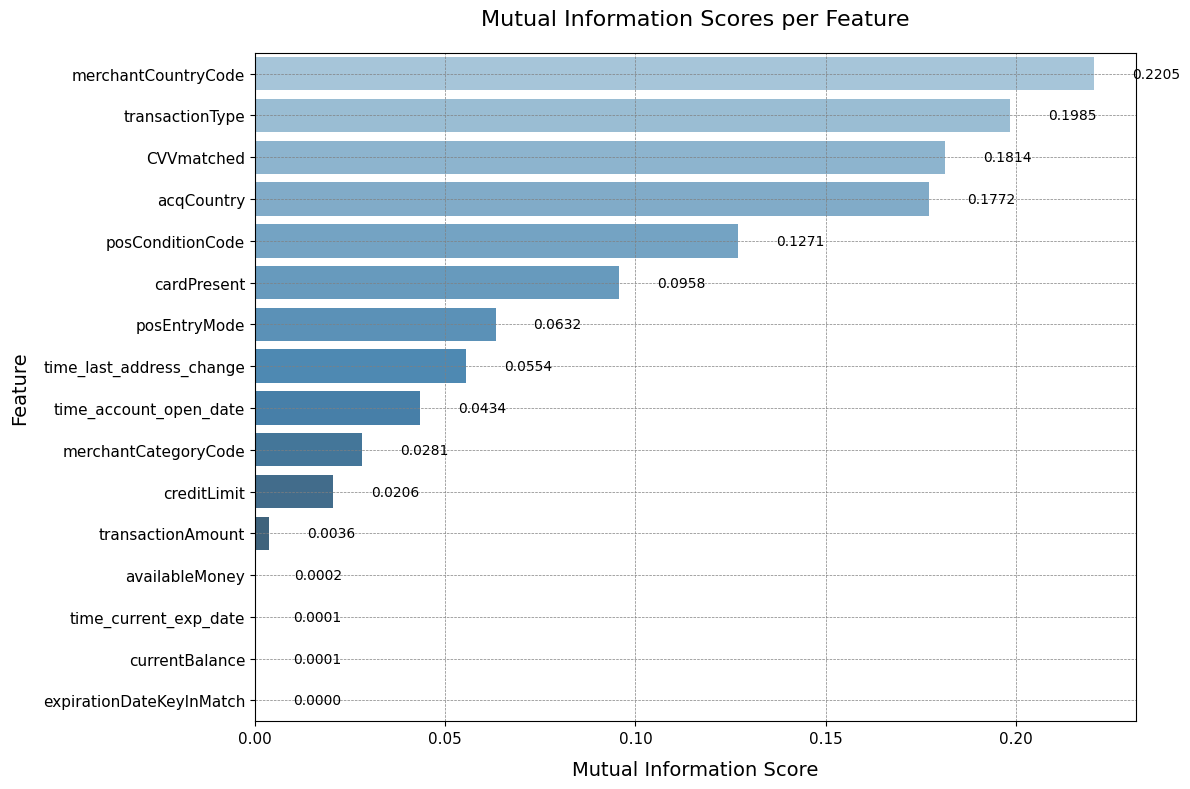

In [ ]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=mi_scores_series.values, y=mi_scores_series.index, orient='h', palette='Blues_d')

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.01,  
            p.get_y() + p.get_height() / 2.,  
            '{:1.4f}'.format(width),  
            va='center',  
            fontsize=10) 

plt.xlabel('Mutual Information Score', fontsize=14, labelpad=10)
plt.ylabel('Feature', fontsize=14, labelpad=10)
plt.title('Mutual Information Scores per Feature', fontsize=16, pad=20)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')  
plt.tight_layout()
plt.show()


# Training a model

The fist thing we do after we curated this nice categorical dataset is to 

In [ ]:
proc_df = pd.get_dummies(proc_df, columns=clean_categorical_features)

In [ ]:
proc_df['isFraud']*1

0         0
1         0
2         0
3         0
4         0
         ..
786358    0
786359    0
786360    0
786361    0
786362    0
Name: isFraud, Length: 786363, dtype: int64

## Define train test split

Now we will define the metrics as well as the data split.

In [ ]:
# This will be useful later
def calculate_metrics(y_true, y_pred):
  # Assuming 'y_true' are the true labels and 'y_pred' are the predicted labels
  metric = {}
  # Accuracy
  accuracy = accuracy_score(y_true, y_pred)
  metric["Accuracy"] = accuracy

  # Precision
  precision = precision_score(y_true, y_pred)
  metric["Precision"] = precision

  # Recall
  recall = recall_score(y_true, y_pred)
  metric["Recall"] = recall

  # F1 score
  f1 = f1_score(y_true, y_pred)
  metric["F1 Score"] = f1

  return metric

In [42]:
# First split: 90% for temp training data and 10% for the test set
train_temp, test = train_test_split(proc_df, test_size=0.1, random_state=42)

# Second split: 1/9 (approximately 11.11%) of the remaining data for validation, so we end up with 80% for training and 10% for validation
train, valid = train_test_split(train_temp, test_size=1/9, random_state=42)

## Define Naive Model

For our first model, we will predict based on the frequency of fraudulent records in the training dataset (baseline)

In [43]:
proc_df.head()

,creditLimit,availableMoney,transactionAmount,currentBalance,isFraud,acqCountry_0,acqCountry_1,acqCountry_2,acqCountry_3,acqCountry_4,merchantCountryCode_0,merchantCountryCode_1,merchantCountryCode_2,merchantCountryCode_3,merchantCountryCode_4,posEntryMode_0,posEntryMode_1,posEntryMode_2,posEntryMode_3,posEntryMode_4,posEntryMode_5,posConditionCode_0,posConditionCode_1,posConditionCode_2,posConditionCode_3,merchantCategoryCode_0,merchantCategoryCode_1,merchantCategoryCode_2,merchantCategoryCode_3,merchantCategoryCode_4,merchantCategoryCode_5,merchantCategoryCode_6,merchantCategoryCode_7,merchantCategoryCode_8,merchantCategoryCode_9,merchantCategoryCode_10,merchantCategoryCode_11,merchantCategoryCode_12,merchantCategoryCode_13,merchantCategoryCode_14,merchantCategoryCode_15,merchantCategoryCode_16,merchantCategoryCode_17,merchantCategoryCode_18,transactionType_0,transactionType_1,transactionType_2,transactionType_3,cardPresent_0,cardPresent_1,expirationDateKeyInMatch_0,expirationDateKeyInMatch_1,time_last_address_change_0,time_last_address_change_1,time_last_address_change_2,time_last_address_change_3,time_last_address_change_4,time_account_open_date_0,time_account_open_date_1,time_account_open_date_2,time_account_open_date_3,time_account_open_date_4,time_current_exp_date_0,CVVmatched_0,CVVmatched_1
0,5000.0,5000.0,98.55,0.0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1
1,5000.0,5000.0,74.51,0.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1
2,5000.0,5000.0,7.47,0.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1
3,5000.0,5000.0,7.47,0.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1
4,5000.0,5000.0,71.18,0.0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1


In [44]:
normalized_freq = train['isFraud'].value_counts(normalize=True)[0]

class NaiveModel:
    def __init__(self, df: pd.DataFrame, target_frequency: float):

        self.df = df
        self.target_frequency = target_frequency

    def _sample(self):

        return np.random.uniform() > self.target_frequency

    def predict(self):

        predictions = self.df.apply(lambda x: self._sample(), axis=1)
        return predictions.values

# Instantiate and use the NaiveModel
naive_model = NaiveModel(df=train, target_frequency=normalized_freq)
naive_pred = naive_model.predict()

y_true = train['isFraud'].values 

naive_metrics = calculate_metrics(y_true, naive_pred)
print('Naive Model Metrics:', naive_metrics)

Naive Model Metrics: {'Accuracy': 0.9687993272811956, 'Precision': 0.016976393771973883, 'Recall': 0.016881430426530817, 'F1 Score': 0.016928778924171092}


## Define Decision Tree Model

In [45]:
proc_df.head()

,creditLimit,availableMoney,transactionAmount,currentBalance,isFraud,acqCountry_0,acqCountry_1,acqCountry_2,acqCountry_3,acqCountry_4,merchantCountryCode_0,merchantCountryCode_1,merchantCountryCode_2,merchantCountryCode_3,merchantCountryCode_4,posEntryMode_0,posEntryMode_1,posEntryMode_2,posEntryMode_3,posEntryMode_4,posEntryMode_5,posConditionCode_0,posConditionCode_1,posConditionCode_2,posConditionCode_3,merchantCategoryCode_0,merchantCategoryCode_1,merchantCategoryCode_2,merchantCategoryCode_3,merchantCategoryCode_4,merchantCategoryCode_5,merchantCategoryCode_6,merchantCategoryCode_7,merchantCategoryCode_8,merchantCategoryCode_9,merchantCategoryCode_10,merchantCategoryCode_11,merchantCategoryCode_12,merchantCategoryCode_13,merchantCategoryCode_14,merchantCategoryCode_15,merchantCategoryCode_16,merchantCategoryCode_17,merchantCategoryCode_18,transactionType_0,transactionType_1,transactionType_2,transactionType_3,cardPresent_0,cardPresent_1,expirationDateKeyInMatch_0,expirationDateKeyInMatch_1,time_last_address_change_0,time_last_address_change_1,time_last_address_change_2,time_last_address_change_3,time_last_address_change_4,time_account_open_date_0,time_account_open_date_1,time_account_open_date_2,time_account_open_date_3,time_account_open_date_4,time_current_exp_date_0,CVVmatched_0,CVVmatched_1
0,5000.0,5000.0,98.55,0.0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1
1,5000.0,5000.0,74.51,0.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1
2,5000.0,5000.0,7.47,0.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1
3,5000.0,5000.0,7.47,0.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1
4,5000.0,5000.0,71.18,0.0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1


In [46]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

class XGBoostModel:
    def __init__(self, dataframe: pd.DataFrame, target_col: str):

        self.feature_columns = [col for col in dataframe.columns if col != target_col]  # Use target_col parameter
        self.target_col = target_col
        self.model = xgb.XGBRFClassifier()

    def train(self, train_df, valid_df=None):

        X_train = train_df.drop(self.target_col, axis=1)
        y_train = train_df[self.target_col]
        self.model.fit(X_train, y_train)

    def predict(self, test_df):

        X_test = test_df[self.feature_columns]
        return self.model.predict(X_test)


xgb_model = XGBoostModel(proc_df, 'isFraud')

xgb_model.train(train, valid)

predictions = xgb_model.predict(test)

y_test = test['isFraud']
xgb_metrics = calculate_metrics(y_test, predictions)
print(xgb_metrics)

{'Accuracy': 0.9846382746035581, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Dealing with an unbalanced dataset.

In [47]:
def define_datasets(categorical_columns, target_col, *args):

  train_xgb, valid_xgb, test_xgb = args[0][categorical_columns], args[1][categorical_columns], args[2][categorical_columns]
  categorical_columns: list = [_col for _col in categorical_columns if _col != target_col]

  X_train, y_train = train_xgb.drop(target_col, axis=1), train_xgb[[target_col]],
  X_valid, y_valid = valid_xgb.drop(target_col, axis=1),  valid_xgb[[target_col]]
  X_test, y_test = test_xgb.drop(target_col, axis=1), test_xgb[[target_col]]

  return pd.get_dummies(X_train, columns=categorical_columns), y_train, pd.get_dummies(X_valid, columns=categorical_columns), y_valid, pd.get_dummies(X_test, columns=categorical_columns), y_test

In [48]:
# First split: 90% for temp training data and 10% for the test set
train_temp, test = train_test_split(proc_df, test_size=0.1, random_state=42)

# Second split: 1/9 (approximately 11.11%) of the remaining data for validation, so you end up with 80% for training and 10% for validation
train, valid = train_test_split(train_temp, test_size=1/9, random_state=42)


# Separate the DataFrame into two subsets: one for fraud and one for non-fraud
fraud_df = train[train['isFraud'] == True]
non_fraud_df = train[train['isFraud'] == False]

# Slash the number of 'False' fraud cases by 70%
reduced_non_fraud_df = non_fraud_df.sample(frac=0.01, random_state=1)  # Change random_state for different randomness
train_reduced = pd.concat([reduced_non_fraud_df, fraud_df])

xgb_model = XGBoostModel(proc_df, 'isFraud')

xgb_model.train(train_reduced, valid)
predictions = xgb_model.predict(test)
y_test = test['isFraud']
xgb_metrics = calculate_metrics(y_test, predictions)  # Ensure calculate_metrics is defined
print(xgb_metrics)

{'Accuracy': 0.5101033864465837, 'Precision': 0.024927432907266893, 'Recall': 0.8104304635761589, 'F1 Score': 0.048367175534805594}


# Conclusion

This project focused on constructing a classification model to identify fraudelent and non-fraudelent transactions. Using data as our guide, we were able to make necessary compromises to explore this space.

Our last approach gave us an `F1` score of `0.04` that could be improved if we did not ignore the temporal relationship of this data. Fraud and anomaly detection have a plethora in common and one particular feature I was considering is the following:

`Rolling averages/std of transactions`: Given a compression of historical transactions (such as average spending, or various other fairly stable metrics) into a feature would be indicative of fraud in ways that static data is not. One way to do this is by considering the following feature:

In [ ]:
df['average_spending'] = df.groupby('accountNumber')['transactionAmount'].expanding().mean().shift().reset_index(level=0, drop=True)

The above could be used more generally in cases where accounting for history is more informative than only the present. Various exciting techniques such as using transformers to train on offline data could really shine in time-series data.